# Nintendo Tweets Modeling

We've arrived at the modeling phase of the project. As a recap, our data is imbalanced with positively labeled tweets being the large majority and negative tweets being the minority. As such, it is important that our models are able to accurately detect negative tweets, even if it comes at the expense of accurately detecting positive tweets. The primary performance metric we will be looking at is recall, as it tells us how many negative tweets the model is able to correctly label.

Because this is a binary classification problem, we will be building a variety of classification models suited for this kind of problem. I will be working with LogisticRegression, RandomForestClassifier, XGBClassifier, and SVC.

In [1]:
# imports

import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import datetime
import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# reading in files

path = "/Users/jasonzhou/Documents/GitHub/NintendoTweets/Documents/Capstone3"
os.chdir(path)

smashtraining = pd.read_csv('smashtraining.csv')
firetraining = pd.read_csv('firetraining.csv')
partytraining = pd.read_csv('partytraining.csv')

smashsamples = pd.read_csv('smashsamples.csv')
firesamples = pd.read_csv('firesamples.csv')
partysamples = pd.read_csv('partysamples.csv')

In [3]:
# function that creates count vectorizers of corpus, and returns counts array, feature names, 
# and the vectorizer itself

def makeCountVec(df):
    vectorizer = CountVectorizer(min_df=0)
    vectorizer.fit(df['cleanedtext'])
    array = vectorizer.transform(df['cleanedtext'])
    array = array.toarray()
    features = vectorizer.get_feature_names()
    return array, features, vectorizer

In [4]:
smashX, smashfeatures, smashvectorizer = makeCountVec(smashtraining)
smashy = smashtraining['label']

fireX, firefeatures, firevectorizer, = makeCountVec(firetraining)
firey = firetraining['label']

partyX, partyfeatures, partyvectorizer = makeCountVec(partytraining)
partyy = partytraining['label']

Here what we need to do is remove the rows corresponding to the manually labeled samples we will use to ultimately validate the models on the accuracy of TextBlob. Because of our work during the preprocessing phase of the project, I just need to drop the last n rows of each X matrix, with n corresponding to the length of each sample.

The reason we do this after the vectorizing instead of before is so that the vectorizers are able to fit to every token in the data. 

In [5]:
smashX = smashX[:-len(smashsamples),]
fireX = fireX[:-len(firesamples), :]
partyX = partyX[:-len(partysamples), :]

In [6]:
# Need to do the same for the y vectors too

smashy = smashy[:-len(smashsamples)]
firey = firey[:-len(firesamples)]
partyy = partyy[:-len(partysamples)]

For reference, each game will be mapped to a number, in the interest of variable name lengths:

- Smash Bros. Ultimate: 1

- Fire Emblem: Three Houses: 2

- Super Mario Party: 3

In [7]:
from sklearn.model_selection import train_test_split

Xtr1, Xte1, ytr1, yte1 = train_test_split(smashX, smashy, test_size=0.3, random_state=1, stratify = smashy)
Xtr2, Xte2, ytr2, yte2 = train_test_split(fireX, firey, test_size=0.3, random_state=1, stratify = firey)
Xtr3, Xte3, ytr3, yte3 = train_test_split(partyX, partyy, test_size=0.3, random_state=1, stratify = partyy)

Now that we have training and testing data for each of our collection of tweets, I'm going to be looking at the baseline performances of four models on each of our data sets. The four models are the following:

- Logistic Regression
- Random Forest Classifier
- XGBClassifier
- SVC

I'm going to determine the performance of each of these models using a baseline version of each. Each different type of model will be tested on each of our sets of data, which means we are going to end up with 12 sets of results in the end, that will be compiled into a table. 

Below defined are helper functions that will help not only to create baseline models but to determine their performance by printing out classification reports and confusion matrices. 

In [8]:
from matplotlib.ticker import IndexLocator
import itertools
from sklearn.metrics import classification_report

def plot_cm(y_test,y_pred_class,classes=['NON-default','DEFAULT']):
    # plot confusion matrix
    fig, ax = plt.subplots()
    cm = confusion_matrix(y_test, y_pred_class)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    plt.title("Confusion Matrix")
    ax.set(yticks=[-0.5, 1.5], 
           xticks=[0, 1], 
           yticklabels=classes, 
           xticklabels=classes)
    ax.yaxis.set_major_locator(IndexLocator(base=1, offset=0.5))
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def scores(y_test, y_pred_class):
    # Prints formatted classification metrics. 
    #print('Classification Accuracy: ', format(accuracy_score(y_test, y_pred_class), '.3f'))
    #print('Precision score: ', format(precision_score(y_test, y_pred_class), '.3f'))
    #print('Recall score: ', format(recall_score(y_test, y_pred_class), '.3f'))
    #print('F1 score: ', format(f1_score(y_test, y_pred_class), '.3f'))
    
    target_names = ['positive tweets', 'negativetweets']
    print(classification_report(y_test, y_pred_class, target_names=target_names))

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC

def logiRegr(X_train, y_train, X_test, y_test,**kwargs):
    # Instantiate model. Use kwargs to pass parameters.
    # Pass GridSearch best_params with ** to unpack.
    logreg = LogisticRegression(random_state=1,**kwargs)
    # Fit to training data.
    logreg.fit(X_train, y_train)
    # Examine coefficients
    #pprint.pprint(list(zip(X_train.columns,logreg.coef_[0])))
    # Class predictions (not predicted probabilities)
    print("Performance on Training Data")
    y_pred_class = logreg.predict(X_train)
    scores(y_train, y_pred_class)
    
    print("Performance on Testing Data")
    y_pred_class = logreg.predict(X_test)
    scores(y_test, y_pred_class)
    # Plot confusion matrix
    #plot_cm(y_test,y_pred_class)
    
def randomForest(X_train, y_train, X_test, y_test,**kwargs):
    # Instantiate model. Use kwargs to pass parameters.
    # Pass GridSearch best_params with ** to unpack.
    rf = RandomForestClassifier(random_state=1, **kwargs) 
    # Fit to training data.
    rf.fit(X_train,y_train)
    # Class predictions
    y_pred_class = rf.predict(X_test)
    # Scoring metrics
    scores(y_test, y_pred_class)
    # Confusion matrix
    #plot_cm(y_test,y_pred_class)
    
def xgbClass(X_train, y_train, X_test, y_test,**kwargs):
    # Instantiate model. Use kwargs to pass parameters.
    # Pass GridSearch best_params with ** to unpack.
    xg = xgb.XGBClassifier(seed=1,**kwargs)
    # Fit to training data.
    xg.fit(X_train,y_train)
    # Class predictions
    y_pred_class = xg.predict(X_test)
    # Scoring metrics
    scores(y_test, y_pred_class)
    # Confusion matrix
    #plot_cm(y_test,y_pred_class)
    
def svmClass(X_train, y_train, X_test, y_test, **kwargs):
    # Instantiate model. Use kwargs to pass parameters.
    # Pass GridSearch best_params with ** to unpack.
    svm = SVC(random_state=1,**kwargs)
    # Fit to training data.
    svm.fit(X_train, y_train)
    # Class predictions
    print("Performance on Training Data")
    y_pred_class = svm.predict(X_train)
    scores(y_train, y_pred_class)
    
    print("Performance on Testing Data")
    y_pred_class = svm.predict(X_test)
    scores(y_test, y_pred_class)

Here we're going to be creating and evaluating baseline models for each game. 4 types of models for 3 games, feel free to skip the lengthy amount of output, there will be a table at the end that summarizes the results.

In [32]:
logiRegr(Xtr1, ytr1, Xte1, yte1)

Performance on Training Data
                 precision    recall  f1-score   support

positive tweets       0.99      1.00      1.00      8052
 negativetweets       0.98      0.85      0.91       458

       accuracy                           0.99      8510
      macro avg       0.98      0.92      0.95      8510
   weighted avg       0.99      0.99      0.99      8510

Performance on Testing Data
                 precision    recall  f1-score   support

positive tweets       0.98      1.00      0.99      3452
 negativetweets       0.90      0.70      0.79       196

       accuracy                           0.98      3648
      macro avg       0.94      0.85      0.89      3648
   weighted avg       0.98      0.98      0.98      3648



In [11]:
randomForest(Xtr1, ytr1, Xte1, yte1)

                 precision    recall  f1-score   support

positive tweets       0.99      0.99      0.99      3452
 negativetweets       0.88      0.82      0.85       196

       accuracy                           0.98      3648
      macro avg       0.93      0.90      0.92      3648
   weighted avg       0.98      0.98      0.98      3648



In [12]:
xgbClass(Xtr1, ytr1, Xte1, yte1)

                 precision    recall  f1-score   support

positive tweets       0.99      0.99      0.99      3452
 negativetweets       0.89      0.77      0.83       196

       accuracy                           0.98      3648
      macro avg       0.94      0.88      0.91      3648
   weighted avg       0.98      0.98      0.98      3648



In [33]:
svmClass(Xtr1, ytr1, Xte1, yte1)

Performance on Training Data
                 precision    recall  f1-score   support

positive tweets       0.99      1.00      1.00      8052
 negativetweets       0.98      0.89      0.93       458

       accuracy                           0.99      8510
      macro avg       0.99      0.94      0.96      8510
   weighted avg       0.99      0.99      0.99      8510

Performance on Testing Data
                 precision    recall  f1-score   support

positive tweets       0.98      1.00      0.99      3452
 negativetweets       0.94      0.70      0.80       196

       accuracy                           0.98      3648
      macro avg       0.96      0.85      0.90      3648
   weighted avg       0.98      0.98      0.98      3648



In [34]:
logiRegr(Xtr2, ytr2, Xte2, yte2)

Performance on Training Data
                 precision    recall  f1-score   support

positive tweets       0.99      1.00      1.00       912
 negativetweets       1.00      0.65      0.79        17

       accuracy                           0.99       929
      macro avg       1.00      0.82      0.89       929
   weighted avg       0.99      0.99      0.99       929

Performance on Testing Data
                 precision    recall  f1-score   support

positive tweets       0.99      0.99      0.99       391
 negativetweets       0.67      0.50      0.57         8

       accuracy                           0.98       399
      macro avg       0.83      0.75      0.78       399
   weighted avg       0.98      0.98      0.98       399



In [15]:
randomForest(Xtr2, ytr2, Xte2, yte2)

                 precision    recall  f1-score   support

positive tweets       0.98      1.00      0.99       391
 negativetweets       1.00      0.25      0.40         8

       accuracy                           0.98       399
      macro avg       0.99      0.62      0.70       399
   weighted avg       0.99      0.98      0.98       399



In [16]:
xgbClass(Xtr2, ytr2, Xte2, yte2)

                 precision    recall  f1-score   support

positive tweets       0.99      0.99      0.99       391
 negativetweets       0.67      0.50      0.57         8

       accuracy                           0.98       399
      macro avg       0.83      0.75      0.78       399
   weighted avg       0.98      0.98      0.98       399



In [35]:
svmClass(Xtr2, ytr2, Xte2, yte2)

Performance on Training Data
                 precision    recall  f1-score   support

positive tweets       1.00      1.00      1.00       912
 negativetweets       1.00      0.76      0.87        17

       accuracy                           1.00       929
      macro avg       1.00      0.88      0.93       929
   weighted avg       1.00      1.00      1.00       929

Performance on Testing Data
                 precision    recall  f1-score   support

positive tweets       0.98      1.00      0.99       391
 negativetweets       1.00      0.25      0.40         8

       accuracy                           0.98       399
      macro avg       0.99      0.62      0.70       399
   weighted avg       0.99      0.98      0.98       399



In [36]:
logiRegr(Xtr3, ytr3, Xte3, yte3)

Performance on Training Data
                 precision    recall  f1-score   support

positive tweets       0.99      1.00      0.99       493
 negativetweets       1.00      0.77      0.87        31

       accuracy                           0.99       524
      macro avg       0.99      0.89      0.93       524
   weighted avg       0.99      0.99      0.99       524

Performance on Testing Data
                 precision    recall  f1-score   support

positive tweets       0.95      1.00      0.97       211
 negativetweets       1.00      0.21      0.35        14

       accuracy                           0.95       225
      macro avg       0.98      0.61      0.66       225
   weighted avg       0.95      0.95      0.94       225



In [20]:
randomForest(Xtr3, ytr3, Xte3, yte3)

                 precision    recall  f1-score   support

positive tweets       0.95      1.00      0.97       211
 negativetweets       0.67      0.14      0.24        14

       accuracy                           0.94       225
      macro avg       0.81      0.57      0.60       225
   weighted avg       0.93      0.94      0.92       225



In [21]:
xgbClass(Xtr3, ytr3, Xte3, yte3)

                 precision    recall  f1-score   support

positive tweets       0.95      0.98      0.97       211
 negativetweets       0.50      0.29      0.36        14

       accuracy                           0.94       225
      macro avg       0.73      0.63      0.67       225
   weighted avg       0.93      0.94      0.93       225



In [37]:
svmClass(Xtr3, ytr3, Xte3, yte3)

Performance on Training Data
                 precision    recall  f1-score   support

positive tweets       0.99      1.00      0.99       493
 negativetweets       1.00      0.77      0.87        31

       accuracy                           0.99       524
      macro avg       0.99      0.89      0.93       524
   weighted avg       0.99      0.99      0.99       524

Performance on Testing Data
                 precision    recall  f1-score   support

positive tweets       0.94      1.00      0.97       211
 negativetweets       1.00      0.07      0.13        14

       accuracy                           0.94       225
      macro avg       0.97      0.54      0.55       225
   weighted avg       0.95      0.94      0.92       225



There are disparities in the performance of our Logisitic Regression and SVM models when they are predicting training and testing data. This indicates overfitting, and additional hyperparameter tuning will be performed to address this.

Due to the imbalanced nature of our data set, the challenge here is building a model that can more accurately identify the minority class, which in this case is 'negative tweets'. Because the models will have little issue identifying positive tweets either way, the key metric of performance here will be the recall score on negative tweets.

To summarize the proportion of positive and negative labels in our training data sets:

In [23]:
ytr1.value_counts()

0    8052
1     458
Name: label, dtype: int64

In [24]:
ytr2.value_counts()

0    912
1     17
Name: label, dtype: int64

In [25]:
ytr3.value_counts()

0    493
1     31
Name: label, dtype: int64

Based on this information, we can assign weights to each class of each training data set, to use in tuning our models.

In [40]:
weights1 = {0: 1, 1: 8052/458}
weights2 = {0: 1, 1: 912/17}
weights3 = {0: 1, 1: 493/31}

# Summary of Recall Scores of Negative Tweets

Game1: Smash Bros Ultimate

Game2: Fire Emblem: Three Houses

Game3: Super Mario Party


|      |Game1 |Game2 |Game3 |
|------|------|------|------|
|LogReg|0.700 |0.500 |0.210 |
|RanFor|0.820 |0.250 |0.140 |
|XGB   |0.770 |0.500 |0.290 |
|SVM   |0.700 |0.250 |0.070 |

# Hyperparameter Tuning

In [46]:
# Function that prints results of gridsearch of hyperparameters

def printGridResult(grid_result):
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

WARNING: Long walls of outputs incoming. 12 sets of hyperparameter tuning performed, one for each model for each game (4x3). Results summarized at the end.

Note: many different variable names are defined and deleted after they're done being used to ensure that as much memory is freed up as possible, in case python's garbage collection isn't doing a good enough job.

# Logistic Regression Models Hyperparameter Tuning

The baseline LogisticRegression model has default parameters of solver='lbgfs' and C=1.0. Let's test some different values for these parameters to see if there's a model with different parameters that yields a higher recall score.

In [48]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

solvers = ['newton-cg', 'lbfgs', 'saga']
c_values = [100, 10, 1.0, 0.1, 0.01]
class_weight = [None, weights1]

grid = dict(solver=solvers,C=c_values, class_weight=class_weight)
model1 = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
grid_search1 = GridSearchCV(estimator=model1, param_grid=grid, n_jobs=4, cv=cv, scoring='recall',error_score=0)
grid_result1 = grid_search1.fit(Xtr1, ytr1)
printGridResult(grid_result1)
del grid_result1, grid_search1, model1

Best: 0.932370 using {'C': 0.01, 'class_weight': {0: 1, 1: 17.580786026200872}, 'solver': 'saga'}


In [49]:
class_weight = [None, weights2]

grid = dict(solver=solvers,C=c_values, class_weight=class_weight)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

model2 = LogisticRegression()
grid_search2 = GridSearchCV(estimator=model2, param_grid=grid, n_jobs=4, cv=cv, scoring='recall',error_score=0)
grid_result2 = grid_search2.fit(Xtr2, ytr2)
printGridResult(grid_result2)
del grid_search2, grid_result2, model2

Best: 1.000000 using {'C': 0.01, 'class_weight': {0: 1, 1: 53.64705882352941}, 'solver': 'newton-cg'}


In [50]:
class_weight = [None, weights3]

grid = dict(solver=solvers,C=c_values, class_weight=class_weight)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

model3 = LogisticRegression()
grid_search3 = GridSearchCV(estimator=model3, param_grid=grid, n_jobs=4, cv=cv, scoring='recall',error_score=0)
grid_result3 = grid_search3.fit(Xtr3, ytr3)
printGridResult(grid_result3)
del grid_search3, grid_result3, model3

Best: 0.904762 using {'C': 0.01, 'class_weight': {0: 1, 1: 15.903225806451612}, 'solver': 'newton-cg'}


# Random Forest Models Hyperparameter Tuning

The baseline RandomForestClassifier has a default of n_estimators=100. More trees in general will always improve the performance of the model, so we'll test n_estimators=1000 to see if there's a significant improvement in performance. We'll also play around with the max_features parameter. 

In [51]:
model4 = RandomForestClassifier()

class_weight = [None, weights1]
n_estimators = [100, 1000]
max_features = ['sqrt', 'log2']
grid = dict(class_weight=class_weight, n_estimators=n_estimators, max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

grid_search4 = GridSearchCV(estimator=model4, param_grid=grid, n_jobs=4, cv=cv, scoring='recall',error_score=0)
grid_result4 = grid_search4.fit(Xtr1, ytr1)
printGridResult(grid_result4)
del grid_search4, grid_result4, model4

Best: 0.827520 using {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 100}


In [52]:
model5 = RandomForestClassifier()

class_weight = [None, weights2]
grid = dict(class_weight=class_weight, n_estimators=n_estimators, max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

grid_search5 = GridSearchCV(estimator=model5, param_grid=grid, n_jobs=4, cv=cv, scoring='recall',error_score=0)
grid_result5 = grid_search5.fit(Xtr2, ytr2)
printGridResult(grid_result5)
del grid_search5, grid_result5, model5

Best: 0.116667 using {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 1000}


In [53]:
model6 = RandomForestClassifier()

class_weight = [None, weights3]
grid = dict(class_weight=class_weight, n_estimators=n_estimators, max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

grid_search6 = GridSearchCV(estimator=model6, param_grid=grid, n_jobs=4, cv=cv, scoring='recall',error_score=0)
grid_result6 = grid_search6.fit(Xtr3, ytr3)
printGridResult(grid_result6)
del grid_search6, grid_result6, model6

Best: 0.280952 using {'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 100}


# XGBoost Models Hyperparameter Tuning

The default parameters for XGBClassifier are max_depth=3, n_estimators=100, and learning_rate=0.1. We'll slightly increase max_depth while testing for different values of the other parameters.

In [54]:
model7 = xgb.XGBClassifier(max_depth=5)

scale_pos_weight = [1, 8052/458]
learning_rate = [0.001, 0.01, 0.1]
n_estimators = [100, 1000]

grid = dict(scale_pos_weight=scale_pos_weight, learning_rate=learning_rate, n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

grid_search7 = GridSearchCV(estimator=model7, param_grid=grid, n_jobs=4, cv=cv, scoring='recall',error_score=0)
grid_result7 = grid_search7.fit(Xtr1, ytr1)
printGridResult(grid_result7)
del grid_search7, grid_result7, model7

Best: 0.984783 using {'learning_rate': 0.001, 'n_estimators': 1000, 'scale_pos_weight': 17.580786026200872}


In [55]:
model8 = xgb.XGBClassifier(max_depth=5)

scale_pos_weight = [1, 912/17]
grid = dict(scale_pos_weight=scale_pos_weight, learning_rate=learning_rate, n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

grid_search8 = GridSearchCV(estimator=model8, param_grid=grid, n_jobs=4, cv=cv, scoring='recall',error_score=0)
grid_result8 = grid_search8.fit(Xtr2, ytr2)
printGridResult(grid_result8)
del grid_search8, grid_result8, model8

Best: 0.766667 using {'learning_rate': 0.001, 'n_estimators': 100, 'scale_pos_weight': 53.64705882352941}


In [56]:
model9 = xgb.XGBClassifier(max_depth=5)

scale_pos_weight = [1, 493/31]
grid = dict(scale_pos_weight=scale_pos_weight, learning_rate=learning_rate, n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

grid_search9 = GridSearchCV(estimator=model9, param_grid=grid, n_jobs=4, cv=cv, scoring='recall',error_score=0)
grid_result9 = grid_search9.fit(Xtr3, ytr3)
printGridResult(grid_result9)
del grid_search9, grid_result9, model9

Best: 0.904762 using {'learning_rate': 0.001, 'n_estimators': 100, 'scale_pos_weight': 15.903225806451612}


# SVM Models Hyperparameter Tuning

The baseline SVC model's default parameters are kernel='rbf', C=1.0. We'll play around with different values of these parameters.

In [57]:
model10 = SVC()

class_weight = [None, weights1]
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(class_weight=class_weight, kernel=kernel,C=C)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

grid_search10 = GridSearchCV(estimator=model10, param_grid=grid, n_jobs=4, cv=cv, scoring='recall',error_score=0)
grid_result10 = grid_search10.fit(Xtr1, ytr1)
printGridResult(grid_result10)
del grid_search10, grid_result10, model10

/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.997826 using {'C': 0.01, 'class_weight': {0: 1, 1: 17.580786026200872}, 'kernel': 'poly'}


In [58]:
model11 = SVC()

class_weight = [None, weights2]

# define grid search
grid = dict(class_weight=class_weight, kernel=kernel,C=C)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
grid_search11 = GridSearchCV(estimator=model11, param_grid=grid, n_jobs=4, cv=cv, scoring='recall',error_score=0)
grid_result11 = grid_search11.fit(Xtr2, ytr2)
printGridResult(grid_result11)
del grid_search11, grid_result11, model11

Best: 1.000000 using {'C': 0.01, 'class_weight': {0: 1, 1: 53.64705882352941}, 'kernel': 'poly'}


In [59]:
model12 = SVC()

class_weight = [None, weights3]

grid = dict(class_weight=class_weight, kernel=kernel,C=C)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
grid_search12 = GridSearchCV(estimator=model12, param_grid=grid, n_jobs=4, cv=cv, scoring='recall',error_score=0)
grid_result12 = grid_search12.fit(Xtr3, ytr3)
printGridResult(grid_result12)
del grid_search12, grid_result12, model12

Best: 1.000000 using {'C': 0.01, 'class_weight': {0: 1, 1: 15.903225806451612}, 'kernel': 'poly'}


Taking the best hyperparameters for each model per game, our recall scores are now the following:


|      |Game1 |Game2 |Game3 |
|------|------|------|------|
|LogReg|0.932 |1.000 |0.905 |
|RanFor|0.828 |0.117 |0.281 |
|XGB   |0.985 |0.767 |0.905 |
|SVM   |0.998 |1.000 |1.000 |

Because during hyperparameter tuning, we only looked at overall recall instead of recall of only negative tweets, the results look much better than they actually are. But based off of this, we can at least understand which models perform better relatively.

Based on the hyperparameter tuning, we'll build models according to the best hyperparameters and get the full classification reports.

- Game 1 (Super Smash Bros Ultimate): SVM, XGB, LogReg
- Game 2 (Fire Emblem: Three Houses): LogReg, SVM
- Game 3 (Super Mario Party): SVM, LogReg, XGB


Let's build each of these models with the optimal hyperparameters, starting with Smash Bros.

Classification Accuracy:  0.983
Precision score:  0.881
Recall score:  0.796
F1 score:  0.836


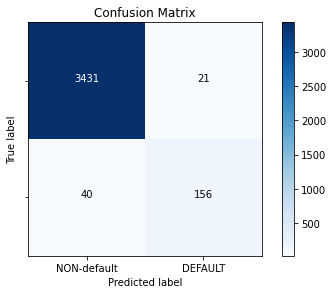

In [63]:
from sklearn.model_selection import cross_validate

smashmodel = RandomForestClassifier(n_estimators=1000, max_features='sqrt')
smashmodel.fit(Xtr1, ytr1)

ypred = smashmodel.predict(Xte1)
scores(yte1, ypred)
plot_cm(yte1, ypred)

cv_results = cross_validate(smashmodel, Xtr1, ytr1, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1'))

In [72]:
def printAverage(cv_results):
    print("Accuracy:", '%.3f'%(cv_results['test_accuracy'].mean()))
    print("Precision:", '%.3f'%(cv_results['test_precision'].mean()))
    print("Recall:", '%.3f'%cv_results['test_recall'].mean())
    print("f1:", '%.3f'%cv_results['test_f1'].mean())

In [73]:
printAverage(cv_results)

Accuracy: 0.984
Precision: 0.890
Recall: 0.799
f1: 0.841


Our recall is realistically closer to 0.800, after using cross validation to account for some variance.

Moving on to Fire Emblem's best performing model:

Accuracy: 0.990
Precision: 0.833
Recall: 0.600
f1: 0.688


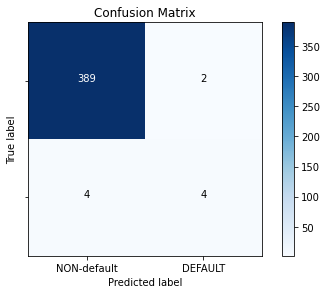

In [114]:
# Fire Emblem's best performing model, with hyperparameters tuned

firemodel = xgb.XGBClassifier(max_depth=5, learning_rate=0.001, n_estimators=100)
firemodel.fit(Xtr2, ytr2)

ypred = firemodel.predict(Xte2)
plot_cm(yte2,ypred)

cv_results = cross_validate(firemodel, Xtr2, ytr2, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1'))
printAverage(cv_results)

Accuracy: 0.982
Precision: 0.866
Recall: 0.785
f1: 0.823


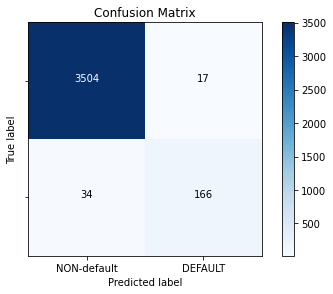

In [78]:
# Mario Party's best performing model

partymodel = RandomForestClassifier()
partymodel.fit(Xtr3, ytr3)

ypred = partymodel.predict(Xte3)
plot_cm(yte3,ypred)

cv_results = cross_validate(partymodel, Xtr3, ytr3, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1'))
printAverage(cv_results)

It's possible that variance was not accounted for when evaluating baseline models, which could possibly have skewed our baseline Random Forest's metrics higher. To be absolutely sure, lets thoroughly evaluate a Random Forest with n_estimators=1000, which may or may not improve performance.

Accuracy: 0.983
Precision: 0.873
Recall: 0.802
f1: 0.836


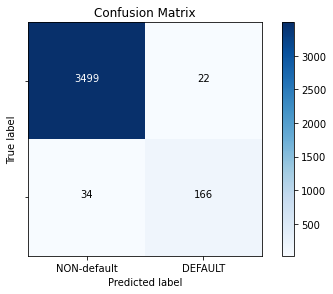

In [79]:
# Mario Party's best performing model, with hyperparameters tuned

partymodel = RandomForestClassifier(n_estimators=1000)
partymodel.fit(Xtr3, ytr3)

ypred = partymodel.predict(Xte3)
plot_cm(yte3,ypred)

cv_results = cross_validate(partymodel, Xtr3, ytr3, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1'))
printAverage(cv_results)

We do get slightly better metrics across the board, looks like this sanity check was worth it.

# Evaluation Against Manually Labeled Data

Going into this, I expect the results to be quite catastrophic actually. While labeling sample data myself, I noticed that there were very rarely tweets that conveyed clear negative sentiment. What doesn't help is when tweets often use a lot of negative words but to actually convey positive sentiment. For example, a tweet in response to Mario Party says, "Oh God no, not Mario Party! That game destroys friendships I tell ya!". Even a human might not initially perceive this tweet as negative without understanding the context of the game. Mario Party is a party game where players need to get themselves ahead while also sabotaging other players to keep them behind. Hence, the "destroys friendships" part. 

Let's just see what the results are.

Classification Accuracy:  0.960
Precision score:  0.800
Recall score:  0.222
F1 score:  0.348


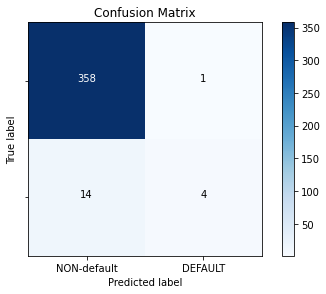

In [89]:
# Evaluating Smash Bros model against manually labeled tweets
smashsamplevec = smashvectorizer.transform(smashsamples['cleanedtext']).toarray()
smashsamplepred = smashmodel.predict(smashsamplevec)
scores(smashsamplepred, smashsamples['label'])
plot_cm(smashsamplepred, smashsamples['label'])

Classification Accuracy:  0.970
Precision score:  0.000
Recall score:  0.000
F1 score:  0.000


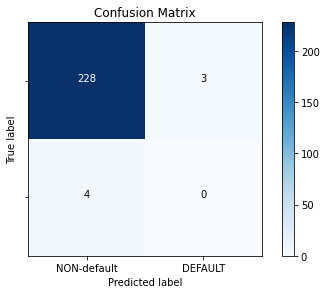

In [90]:
# Evaluating Fire Emblem model against manually labeled tweets
firesamplevec = firevectorizer.transform(firesamples['cleanedtext']).toarray()
firesamplepred = firemodel.predict(firesamplevec)
scores(firesamplepred, firesamples['label'])
plot_cm(firesamplepred, firesamples['label'])

Classification Accuracy:  0.925
Precision score:  0.000
Recall score:  0.000
F1 score:  0.000


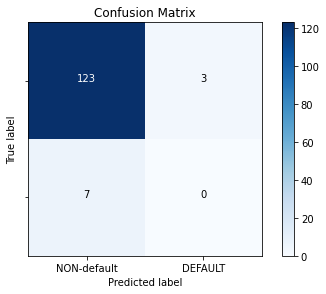

In [88]:
# Evaluating Mario Party model against manually labeled tweets
partysamplevec = partyvectorizer.transform(partysamples['cleanedtext']).toarray()
partysamplepred = partymodel.predict(partysamplevec)
scores(partysamplepred, partysamples['label'])
plot_cm(partysamplepred, partysamples['label'])

# Discussion of Results

These results are rather damning, but not all that suprising. On the surface it appears that our models perform acceptably based on the classification accuracy but this metric is misleading here. Because our data is so imbalanced, even a model that simply predicts every tweet to be positive would also have a high classification accuracy. 

Our data is inherently very imbalanced after being labeled by TextBlob, and even more imbalanced when manually labeled. Furthermore, our approach of representing tweets using bag-of-words representations is likely too crude and loses too much information such as phrases and sentence structure. Regardless, we'll go through the motions of feature analysis on each of the models.

# Feature Importance

Starting with feature importance in Smash Bro's model:

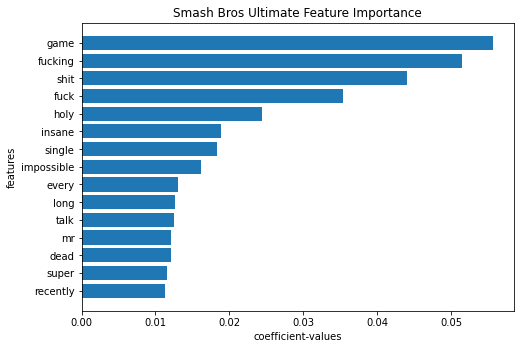

In [109]:
smashfeaturesdf = pd.DataFrame(list(zip(smashfeatures, smashmodel.feature_importances_)), columns=['Features', 'Coefficients'])
smashfeaturesdf = smashfeaturesdf.sort_values(by=['Coefficients'], ascending=False)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('features')
ax.set_xlabel('coefficient-values')
ax.set_title('Smash Bros Ultimate Feature Importance')
ax.invert_yaxis()
_ = ax.barh(smashfeaturesdf['Features'][:15], smashfeaturesdf['Coefficients'][:15])

Some pretty strong language here, even outside of the profanity. Seeing these words here makes sense though because you'd expect words that convey strong feeling to be the biggest influencers of scoring sentiment. It certainly gives us insight as to the words that TextBlob weighs more heavily while performing its own sentiment analysis.

On to Fire Emblem:

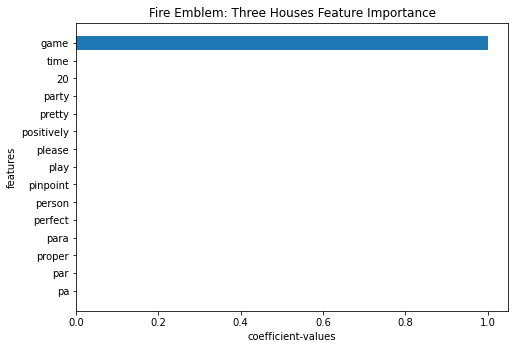

In [115]:
firefeaturesdf = pd.DataFrame(list(zip(firefeatures, firemodel.feature_importances_)), columns=['Features', 'Coefficients'])
firefeaturesdf = firefeaturesdf.sort_values(by=['Coefficients'], ascending=False)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('features')
ax.set_xlabel('coefficient-values')
ax.set_title('Fire Emblem: Three Houses Feature Importance')
ax.invert_yaxis()
_ = ax.barh(firefeaturesdf['Features'][:15], firefeaturesdf['Coefficients'][:15])

In [116]:
firefeaturesdf

,Features,Coefficients
119,game,0.999954
316,time,0.000046
0,20,0.000000
236,party,0.000000
243,pretty,0.000000
...,...,...
117,fucking,0.000000
116,fuck,0.000000
115,freaking,0.000000
114,foot,0.000000


Very interestingly, most features were assigned a coefficient of 0. This does however make sense actually, since Fire Emblem's collection of tweets had by far the most retweets, which will result in many more collinear features. Its TextBlob labels were also the most heavily imbalanced, with about a 53:1 positive:negative label ratio. It's actually no real surprise now that the vast majority of features/tokens were deemed "useless" for classification.

On to Mario Party:

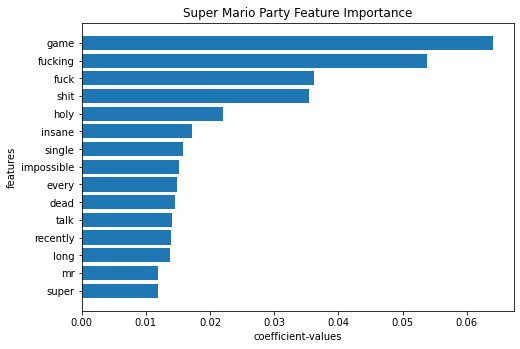

In [113]:
partyfeaturesdf = pd.DataFrame(list(zip(partyfeatures, partymodel.feature_importances_)), columns=['Features', 'Coefficients'])
partyfeaturesdf = partyfeaturesdf.sort_values(by=['Coefficients'], ascending=False)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('features')
ax.set_xlabel('coefficient-values')
ax.set_title('Super Mario Party Feature Importance')
ax.invert_yaxis()
_ = ax.barh(partyfeaturesdf['Features'][:15], partyfeaturesdf['Coefficients'][:15])

This bar chart looks very similar to the chart of Smash Bro's, I even had to look back and forth several times to make sure I didn't accidentally plot Smash Bro's feature data. Again, profanity ranks very high on most important features, along with other words with strong connotations. 

# Conclusions

Unfortunately our modeling turned out to be a failure. Due to the nature of our data, it was very important for our training data and model to be complex enough to be able to accurately detect the rare negative tweets. In other words the tolerance for our false postive rate was extremely low, for the models to be considered acceptable. The problem is that our bag-of-word representations lack the nuance to truly capture sentiment of the original tweets. Not only this, but TextBlob is most likely not an accurate labeler of our documents (tweets) here either. TextBlob's sentiment analysis is based on a model trained on movie reviews. The language used in movie reviews include many more clear postive or negative words, whereas the language used in tweets are more unfocused and include much more slang. Therefore even a bag-of-word representation of a movie review would still retain enough information to reasonably evaluate sentiment off of. Moving forward, the first step to creating models that accurately label tweets, could be to have a large enough training data set of accurately labeled tweets. 